# Toronto emotional speech set (TESS)

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

https://utoronto.scholaris.ca/collections/036db644-9790-4ed0-90cc-be1dfb8a4b66

OAF stands for "Older Adult Female". This refers to the actress aged 64 years.

YAF stands for "Younger Adult Female". This refers to the actress aged 26 years.

In [3]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt

## TESS Dataset

# Download dataset from Kaggle
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("Path to dataset files:", path)
# List all files in the dataset
print(os.listdir(path))
# change name of existing folder on path
os.rename(os.path.join(path, os.listdir(path)[0]), os.path.join(path, "TESS"))

tess_path = os.path.join(path, "TESS")
print(os.listdir(tess_path))


Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1
['TESS']
['YAF_disgust', 'OAF_Pleasant_surprise', 'OAF_happy', 'YAF_sad', 'YAF_happy', 'YAF_neutral', 'OAF_Fear', 'OAF_angry', 'YAF_pleasant_surprised', 'YAF_fear', 'OAF_neutral', 'OAF_disgust', 'YAF_angry', 'OAF_Sad']


<Axes: title={'center': 'Emotion Distribution in TESS'}, xlabel='label'>

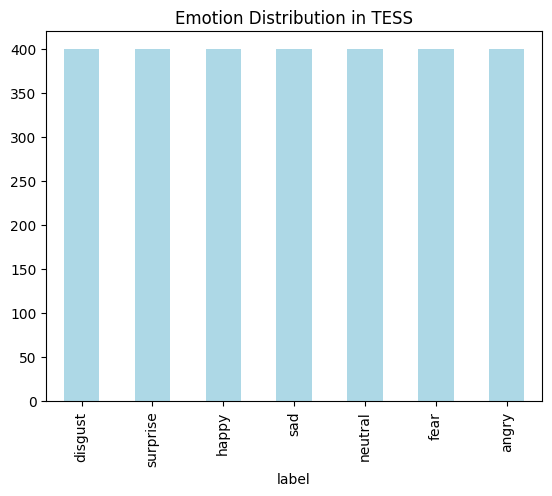

In [4]:
all_files = [
    os.path.join(tess_path, folder, filename)
    for folder in os.listdir(tess_path)
    for filename in os.listdir(os.path.join(tess_path, folder))
]

labels = [
    f[:-4].split('_')[-1].lower() 
    if f[:-4].split('_')[-1].lower() != "ps"
    else "surprise"
    for f in all_files
]

tess_db = pd.DataFrame({
    'filename': all_files,
    'label': labels
})

tess_db['label'].value_counts().plot(kind='bar', color='lightblue', title='Emotion Distribution in TESS')



In [3]:
import sys
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)

from src.recognizers import SpeechEmotionRecognizer
import librosa
from tqdm import tqdm
tqdm.pandas()



# Initialize the assistant
ser = SpeechEmotionRecognizer()
# Analyze the dataset
preds = []
for i in tqdm(range(len(tess_db))):
    filename = tess_db['filename'].iloc[i]
    audio, sr = librosa.load(filename, sr=16000)
    pred = ser.analyze(audio, sr)
    preds.append(pred['emotions'][0])
tess_db['pred'] = preds
tess_db.head()

2025-05-27 18:34:52.062107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 2800/2800 [04:36<00:00, 10.12it/s]


,filename,label,pred
0,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
1,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
2,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
3,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,disgust
4,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust,boredom


              precision    recall  f1-score   support

       angry       0.27      0.04      0.07       400
     boredom       0.00      0.00      0.00         0
     disgust       0.17      0.59      0.27       400
        fear       0.00      0.00      0.00       400
       happy       0.45      0.03      0.06       400
     neutral       1.00      0.00      0.00       400
         sad       0.00      0.00      0.00       400

    accuracy                           0.11      2400
   macro avg       0.27      0.09      0.06      2400
weighted avg       0.31      0.11      0.07      2400



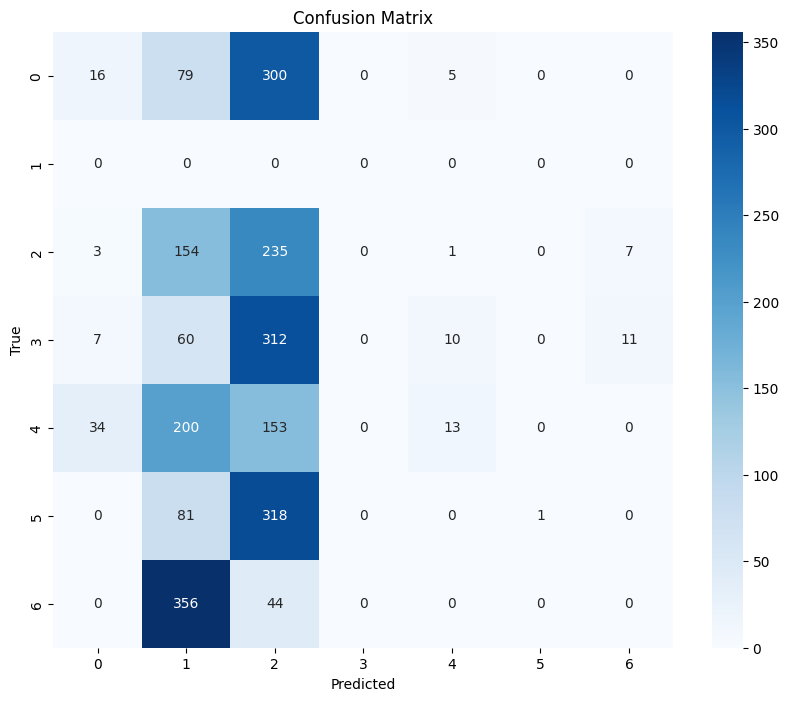

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fuse labels with similar meanings
tess_db['pred'] = tess_db['pred'].replace({
    'anger': 'angry',
    'happiness': 'happy',
    'sadness': 'sad',
    'fearful' : 'fear'
})

tess_db = tess_db[tess_db['label'].isin(['disgust', 'sad', 'boredom', 'angry', 'fear', 'happy', 'neutral'])]

# Generate a classification report
report = classification_report(tess_db['label'], tess_db['pred'])

print(report)
# Generate a confusion matrix
cm = confusion_matrix(tess_db['label'], tess_db['pred'])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') #, xticklabels=emo_order, yticklabels=emo_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [6]:

print(tess_db["label"].unique())
print(tess_db['pred'].unique())

['disgust' 'happy' 'sad' 'neutral' 'fear' 'angry']
['disgust' 'boredom' 'sad' 'angry' 'happy' 'neutral']


# OpenSMILE

In [8]:
# https://audeering.github.io/opensmile-python/
#!pip install opensmile

import opensmile

# Load data and extract features
smile = opensmile.Smile(
    #feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

feats_df = smile.process_files(tess_db["filename"])

feats_df.head()

,,,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
file,start,end,,,,,,,,,,,,,,,,,,,,,
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_date_disgust.wav,0 days,0 days 00:00:02.380765135,33.311512,0.167887,30.233387,33.582432,36.801254,6.567867,37.088375,23.873022,102.139885,78.412605,...,0.015293,-0.013067,0.034128,2.109705,1.724138,0.3225,0.367585,0.2325,0.107558,-33.633442
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_rag_disgust.wav,0 days,0 days 00:00:02.321741624,33.541199,0.221251,30.607704,34.415165,38.339211,7.731506,301.817078,329.956909,47.030148,38.146214,...,0.024138,-0.019726,0.064816,2.597403,1.769912,0.3775,0.378641,0.1625,0.087571,-30.686287
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_raise_disgust.wav,0 days,0 days 00:00:02.646063734,33.721695,0.219033,30.271343,33.172550,39.682961,9.411617,31.068426,20.980042,97.000076,61.183487,...,0.015026,-0.011972,0.027866,2.661597,1.550388,0.4050,0.424882,0.1740,0.142352,-30.999493
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_ditch_disgust.wav,0 days,0 days 00:00:02.542434669,34.361111,0.204392,29.236042,34.488140,37.640064,8.404022,969.197632,1468.279053,60.660587,25.906439,...,-0.006464,-0.011046,0.050418,2.371542,2.016129,0.2680,0.374775,0.2040,0.136176,-33.801414
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS/YAF_disgust/YAF_door_disgust.wav,0 days,0 days 00:00:02.448758909,33.536655,0.219005,28.647896,33.393734,39.124413,10.476517,188.472672,132.225250,106.128799,78.476913,...,-0.016488,-0.003887,0.044019,1.639344,1.673640,0.3850,0.414578,0.1520,0.102645,-28.442787


In [ ]:
#feats_df.to_csv('TESS_GeMAPS_features.csv', index=False)

In [9]:
#!pip install sklearn
from sklearn.model_selection import train_test_split

# Split data
X = feats_df.values
y = tess_db.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(1920, 88) (480, 88)


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Simple SVM(1) classifier without feature scaling (1)
clf11 = svm.SVC(kernel='linear')
clf11.fit(X_train, y_train)
pred11 = clf11.predict(X_test)
print("Performance SVM without feature scaling\n", classification_report(y_test, pred11))

## Simple SVM(1) classifier with feature scaling (2)
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train the model
clf12 = svm.SVC(kernel='linear')
clf12.fit(X_train_scaled, y_train)
pred12 = clf12.predict(X_test_scaled)
print("Performance SVM with feature scaling\n", classification_report(y_test, pred12))

Performance SVM without feature scaling
               precision    recall  f1-score   support

       angry       0.97      1.00      0.98        87
     disgust       0.99      0.99      0.99        74
        fear       1.00      0.99      0.99        68
       happy       1.00      0.96      0.98        85
     neutral       1.00      0.99      0.99        85
         sad       0.96      0.99      0.98        81

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480

Performance SVM with feature scaling
               precision    recall  f1-score   support

       angry       0.99      1.00      0.99        87
     disgust       0.99      1.00      0.99        74
        fear       1.00      0.99      0.99        68
       happy       1.00      1.00      1.00        85
     neutral       1.00      1.00      1.00        85
         sad       1.00      0.99      0.99        81

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf12 = RandomForestClassifier()
clf12.fit(X_train_scaled, y_train)
pred12 = clf12.predict(X_test_scaled)
print("Performance SVM with feature scaling\n", classification_report(y_test, pred12))

Performance SVM with feature scaling
               precision    recall  f1-score   support

       angry       1.00      1.00      1.00        87
     disgust       1.00      0.99      0.99        74
        fear       1.00      1.00      1.00        68
       happy       1.00      1.00      1.00        85
     neutral       1.00      1.00      1.00        85
         sad       0.99      1.00      0.99        81

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [15]:
import glob

# Download dataset from Kaggle
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)
# List all files in the dataset
print(os.listdir(path))

# Define the dataset directory
ravdess_path = path + "/audio_speech_actors_01-24/**/*.wav"

# Codebook that maps RAVDESS filename encoding to emotions
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear', #'fearful',
    '07': 'disgust',
    '08': 'surprise', #'surprised'
}

# Extract emotion labels from filenames
filenames = glob.glob(ravdess_path, recursive=True)
emotions = [emotion_map[os.path.basename(f).split('-')[2]] for f in filenames if os.path.basename(f).split('-')[2] in emotion_map]

rav_db = pd.DataFrame({
    'filename': filenames,
    'label': emotions
})

rav_db.head()

Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'audio_speech_actors_01-24', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']


,filename,label
0,/Users/sofiafernandes/.cache/kagglehub/dataset...,angry
1,/Users/sofiafernandes/.cache/kagglehub/dataset...,fear
2,/Users/sofiafernandes/.cache/kagglehub/dataset...,fear
3,/Users/sofiafernandes/.cache/kagglehub/dataset...,angry
4,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust


In [24]:
rav_feats = smile.process_files(rav_db["filename"])

rav_feats.head()

,,,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
file,start,end,,,,,,,,,,,,,,,,,,,,,
/Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_16/03-01-05-01-02-01-16.wav,0 days,0 days 00:00:03.903895833,36.663185,0.092193,33.923561,36.607681,39.911366,5.987804,234.625992,278.505188,229.474777,402.364685,...,0.088287,0.012799,0.024085,1.799486,1.822917,0.204286,0.120458,0.321429,0.410833,-33.784313
/Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_16/03-01-06-01-02-02-16.wav,0 days,0 days 00:00:03.570229167,38.592869,0.083782,35.799889,39.018208,41.324265,5.524376,41.661167,45.850269,45.512527,26.246408,...,0.111506,0.012556,0.017401,2.808989,1.139601,0.312500,0.162692,0.540000,0.446822,-36.295971
/Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_16/03-01-06-02-01-02-16.wav,0 days,0 days 00:00:03.737062500,47.691246,0.117621,45.381668,46.748459,50.922649,5.540981,173.288620,104.474289,30.014435,10.889656,...,0.062252,0.000030,0.070835,2.419355,1.634877,0.245000,0.206377,0.410000,0.385071,-22.345514
/Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_16/03-01-05-02-01-01-16.wav,0 days,0 days 00:00:03.970645833,39.567497,0.156933,35.898926,40.488960,43.685249,7.786324,168.711563,148.852676,128.481461,119.730644,...,0.074365,0.008484,0.037622,2.525253,1.534527,0.270000,0.163197,0.358333,0.450830,-26.800886
/Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/audio_speech_actors_01-24/Actor_16/03-01-07-01-01-01-16.wav,0 days,0 days 00:00:03.770437500,35.005974,0.106174,31.523083,34.555748,38.189644,6.666561,99.787117,77.171021,34.780659,24.179268,...,0.094444,0.012590,0.030078,2.659575,1.347709,0.238000,0.165094,0.480000,0.446318,-42.832409


In [ ]:
#rav_feats.to_csv('RAVDESS_GeMAPS_features.csv', index=False)

In [7]:

# Split data
emotions = tess_db['label'].unique()
idx = rav_db[rav_db['label'].isin(emotions)].index

X_rav = rav_feats.iloc[idx].values
y_rav = rav_db.iloc[idx].label

Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1
['TESS']
['YAF_disgust', 'OAF_Pleasant_surprise', 'OAF_happy', 'YAF_sad', 'YAF_happy', 'YAF_neutral', 'OAF_Fear', 'OAF_angry', 'YAF_pleasant_surprised', 'YAF_fear', 'OAF_neutral', 'OAF_disgust', 'YAF_angry', 'OAF_Sad']
Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'audio_speech_actors_01-24', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']


NameError: name 'rav_feats' is not defined

In [55]:
## Simple SVM(1) classifier with feature scaling (2)
# Standardize features by removing the mean and scaling to unit variance
X_rav_scaled = scaler.transform([i[:-1] for i in X_rav])
# Predict with model
pred_rav = clf12.predict(X_rav_scaled)
print("Performance SVM with feature scaling\n", classification_report(y_rav, pred_rav))

Performance SVM with feature scaling
               precision    recall  f1-score   support

       angry       0.35      0.35      0.35       192
     disgust       0.25      0.82      0.38       192
        fear       0.39      0.40      0.39       192
       happy       0.20      0.01      0.01       192
     neutral       0.25      0.02      0.04        96
         sad       0.61      0.06      0.10       192

    accuracy                           0.30      1056
   macro avg       0.34      0.28      0.21      1056
weighted avg       0.35      0.30      0.23      1056



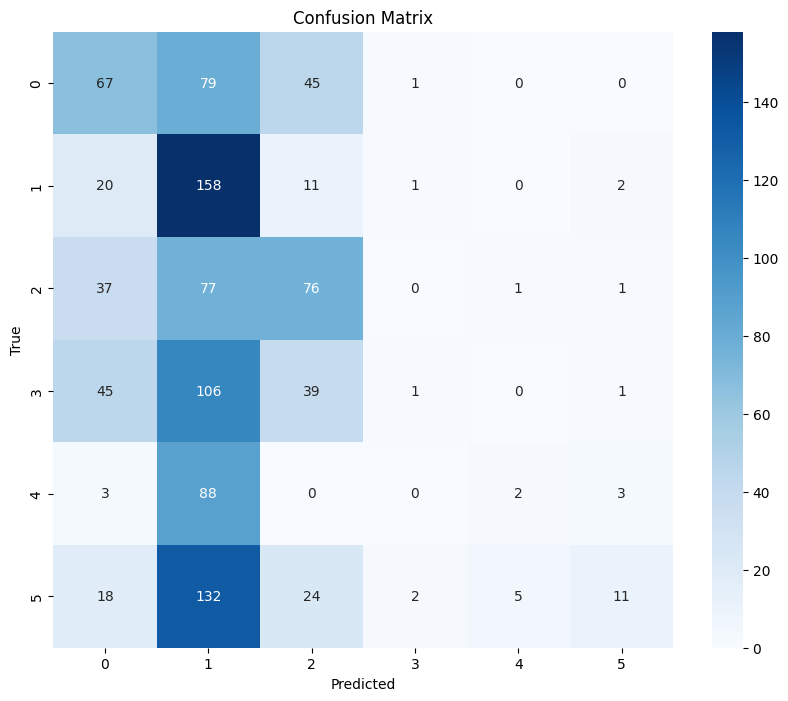

In [56]:
# Generate a confusion matrix
cm = confusion_matrix(y_rav, pred_rav)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') #, xticklabels=emo_order, yticklabels=emo_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [57]:
## EMO-DB Dataset

# Download dataset from Kaggle
path = kagglehub.dataset_download("piyushagni5/berlin-database-of-emotional-speech-emodb")
print("Path to dataset files:", path)

# List all files in the dataset
files = [file_path.name for file_path in os.scandir(path+"/wav") if file_path.is_file()]

# Define the dataset directory
emodb_path = path + "/wav/*.wav"

# Codebook that maps EmoDB filename encoding to emotions
emotion_map = {
    'W': 'angry', #'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happy', #'happiness',
    'T': 'sad', #'sadness',
    'N': 'neutral'
}

# Extract emotion labels from filenames (6th character)
filenames = glob.glob(emodb_path)
emotions = [emotion_map[os.path.basename(f)[5]] for f in filenames if os.path.basename(f)[5] in emotion_map]

# Create a DataFrame to store the emotion labels
emo_db = pd.DataFrame({
    'filename': filenames,
    'label': emotions
})

emo_db.head()


Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1


,filename,label
0,/Users/sofiafernandes/.cache/kagglehub/dataset...,boredom
1,/Users/sofiafernandes/.cache/kagglehub/dataset...,angry
2,/Users/sofiafernandes/.cache/kagglehub/dataset...,fear
3,/Users/sofiafernandes/.cache/kagglehub/dataset...,disgust
4,/Users/sofiafernandes/.cache/kagglehub/dataset...,angry


In [61]:
emo_feats = smile.process_files(emo_db["filename"])

emo_feats.head()

,,,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
file,start,end,,,,,,,,,,,,,,,,,,,,,
/Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/16a02Lb.wav,0 days,0 days 00:00:02.081125,36.145962,0.120175,31.316414,36.366047,40.726501,9.410088,21.147469,14.031230,28.690582,8.217484,...,-0.016520,0.015412,0.260250,3.864734,2.475248,0.246000,0.212659,0.113333,0.052810,-17.709595
/Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/14a07Wc.wav,0 days,0 days 00:00:02.063500,41.152687,0.119568,38.206409,41.596970,43.566231,5.359821,38.043438,41.589668,57.602268,35.204792,...,0.008704,0.011329,0.248952,4.390244,3.500000,0.208571,0.141566,0.072000,0.036551,-19.888117
/Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/10a07Ad.wav,0 days,0 days 00:00:01.603375,29.344051,0.033157,28.594852,29.091187,30.407171,1.812319,121.797241,167.920105,22.221197,13.601577,...,-0.011442,0.016779,0.574719,4.402516,4.545455,0.090000,0.068243,0.107143,0.055988,-18.262444
/Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/13a05Ea.wav,0 days,0 days 00:00:04.195937500,36.554493,0.064922,34.792404,36.899849,38.542122,3.749718,101.899666,151.185745,48.196270,20.018641,...,-0.021964,-0.002345,0.757442,5.502393,3.389830,0.105714,0.087155,0.157333,0.168779,-16.983673
/Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1/wav/14a05Wa.wav,0 days,0 days 00:00:04.006812500,40.611958,0.147944,36.786343,41.586903,44.147541,7.361198,244.031326,170.801331,118.145416,96.427307,...,-0.001218,0.014095,0.279358,5.012531,4.060914,0.151875,0.142004,0.077333,0.033757,-18.152895


In [ ]:
#emo_feats.to_csv('EmoDB_GeMAPS_features.csv', index=False)

In [65]:
emotions = tess_db['label'].unique()
idx = emo_db[emo_db['label'].isin(emotions)].index

X_rav = emo_feats.iloc[idx].values
y_rav = emo_db.iloc[idx].label

## Simple SVM(1) classifier with feature scaling (2)
# Standardize features by removing the mean and scaling to unit variance
X_rav_scaled = scaler.transform(X_rav)
# Predict with model
pred_rav = clf12.predict(X_rav_scaled)
print("Performance SVM with feature scaling\n", classification_report(y_rav, pred_rav))

Performance SVM with feature scaling
               precision    recall  f1-score   support

       angry       0.33      0.53      0.41       127
     disgust       0.05      0.15      0.07        46
        fear       0.17      0.20      0.18        69
       happy       0.00      0.00      0.00        71
     neutral       0.06      0.01      0.02        79
         sad       0.27      0.05      0.08        62

    accuracy                           0.20       454
   macro avg       0.15      0.16      0.13       454
weighted avg       0.17      0.20      0.16       454



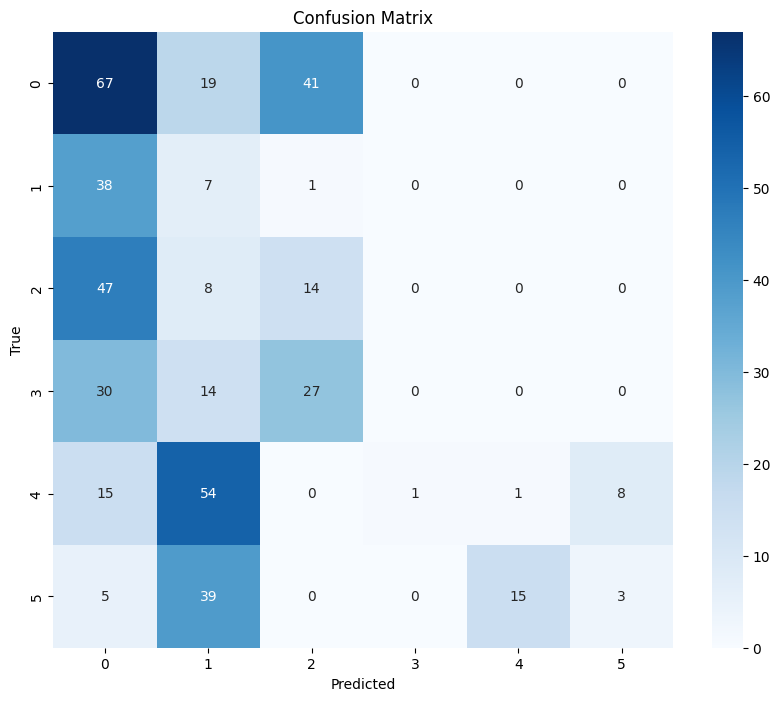

In [66]:
# Generate a confusion matrix
cm = confusion_matrix(y_rav, pred_rav)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') #, xticklabels=emo_order, yticklabels=emo_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Train and evaluate with 3 datasets

In [12]:
import sys
module_path = os.path.abspath(os.path.join('..', '..'))  # or the path to your source code
sys.path.insert(0, module_path)

from src.utils import load_ravdess, load_tess, load_emodb
# Load TESS and RAVDESS datasets
tess_db = load_tess()
rav_db = load_ravdess()
emo_db = load_emodb()
# concatenate
tess_emo_rav = pd.concat([tess_db, emo_db, rav_db])

#all_feats = smile.process_files(tess_emo_rav["filename"])
all_feats = pd.read_csv('./features/TESS_EmoDB_RAVDESS_features.csv')
all_feats

Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1
['TESS']
['YAF_disgust', 'OAF_Pleasant_surprise', 'OAF_happy', 'YAF_sad', 'YAF_happy', 'YAF_neutral', 'OAF_Fear', 'OAF_angry', 'YAF_pleasant_surprised', 'YAF_fear', 'OAF_neutral', 'OAF_disgust', 'YAF_angry', 'OAF_Sad']
Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'audio_speech_actors_01-24', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']
Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1


,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,/Users/sofiafernandes/.cache/kagglehub/dataset...,0 days,0 days 00:00:02.380765135,33.311512,0.167887,30.233387,33.582430,36.801254,6.567867,37.088375,...,0.015293,-0.013067,0.034128,2.109705,1.724138,0.322500,0.367585,0.232500,0.107558,-33.633442
1,/Users/sofiafernandes/.cache/kagglehub/dataset...,0 days,0 days 00:00:02.321741624,33.541200,0.221251,30.607704,34.415165,38.339210,7.731506,301.817080,...,0.024138,-0.019726,0.064816,2.597403,1.769912,0.377500,0.378641,0.162500,0.087571,-30.686287
2,/Users/sofiafernandes/.cache/kagglehub/dataset...,0 days,0 days 00:00:02.646063734,33.721695,0.219033,30.271343,33.172550,39.682960,9.411617,31.068426,...,0.015026,-0.011972,0.027866,2.661597,1.550388,0.405000,0.424882,0.174000,0.142352,-30.999493
3,/Users/sofiafernandes/.cache/kagglehub/dataset...,0 days,0 days 00:00:02.542434669,34.361110,0.204392,29.236042,34.488140,37.640064,8.404022,969.197630,...,-0.006464,-0.011046,0.050418,2.371542,2.016129,0.268000,0.374775,0.204000,0.136176,-33.801414
4,/Users/sofiafernandes/.cache/kagglehub/dataset...,0 days,0 days 00:00:02.448758909,33.536655,0.219005,28.647896,33.393734,39.124413,10.476517,188.472670,...,-0.016488,-0.003887,0.044019,1.639344,1.673640,0.385000,0.414578,0.152000,0.102645,-28.442787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4370,/Users/sofiafernandes/.cache/kagglehub/dataset...,0 days,0 days 00:00:03.937270833,38.136395,0.082155,35.621384,39.419216,40.493355,4.871971,164.967350,...,0.007304,0.007272,0.014186,2.040816,0.775194,0.506667,0.091773,0.570000,0.496639,-36.501630
4371,/Users/sofiafernandes/.cache/kagglehub/dataset...,0 days,0 days 00:00:03.436750,34.502087,0.086906,31.821001,34.341667,36.840748,5.019747,30.288550,...,-0.025129,0.007835,0.008716,2.339181,0.890208,0.430000,0.279404,0.666667,0.440025,-44.086678
4372,/Users/sofiafernandes/.cache/kagglehub/dataset...,0 days,0 days 00:00:03.636958333,32.549720,0.145451,32.592190,33.413900,36.421947,3.829758,4.624880,...,-0.008157,0.005465,0.008949,2.209945,1.680672,0.163333,0.119536,0.351429,0.428133,-52.962883
4373,/Users/sofiafernandes/.cache/kagglehub/dataset...,0 days,0 days 00:00:03.470125,33.988625,0.051731,32.588040,34.082024,35.868362,3.280323,102.553560,...,-0.020109,0.004687,0.011814,2.023121,1.173021,0.267500,0.143069,0.560000,0.491325,-49.797230


In [75]:
tess_emo_rav.to_csv("TESS_EmoDB_RAVDESS.csv")
all_feats.to_csv("TESS_EmoDB_RAVDESS_features.csv")

In [ ]:
tess_emo_rav

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm

X = all_feats.values
y = tess_emo_rav.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

## Simple SVM(1) classifier with feature scaling (2)
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [4375, 4775]

Performance SVM with feature scaling
               precision    recall  f1-score   support

       angry       0.84      0.86      0.85       216
     boredom       0.74      0.71      0.72        24
        calm       0.71      0.62      0.66        58
     disgust       0.80      0.79      0.79       191
        fear       0.81      0.79      0.80       198
       happy       0.74      0.73      0.74       199
     neutral       0.82      0.88      0.85       173
         sad       0.78      0.78      0.78       196
    surprise       0.68      0.71      0.69        58

    accuracy                           0.79      1313
   macro avg       0.77      0.76      0.77      1313
weighted avg       0.79      0.79      0.79      1313



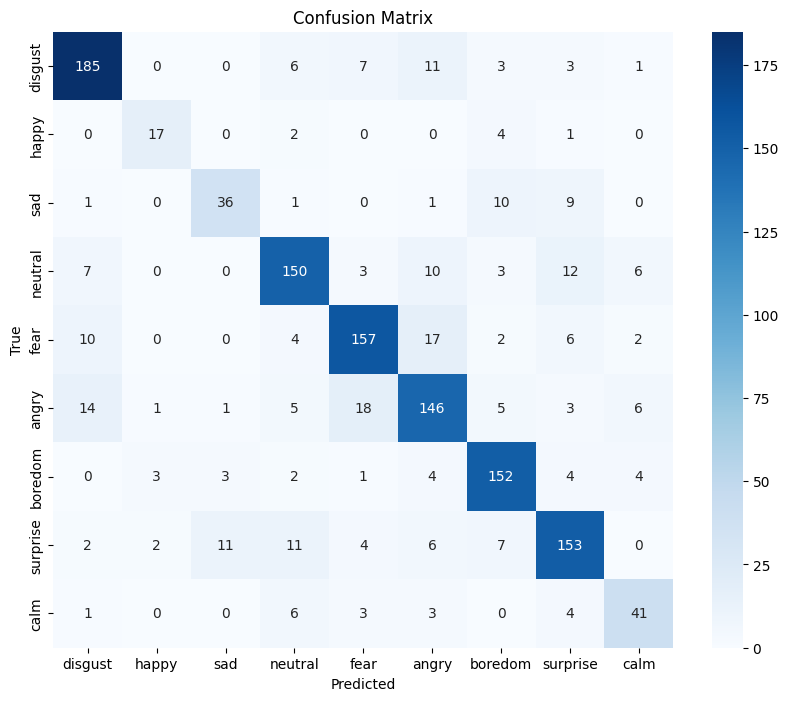

In [78]:

# Train the model
clf12 = svm.SVC(kernel='linear')
clf12.fit(X_train_scaled, y_train)
pred12 = clf12.predict(X_test_scaled)
print("Performance SVM with feature scaling\n", classification_report(y_test, pred12))

# Generate a confusion matrix
cm = confusion_matrix(y_test, pred12)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Performance RandomForest with feature scaling
               precision    recall  f1-score   support

       angry       0.85      0.89      0.87       216
     boredom       0.92      0.92      0.92        24
        calm       0.68      0.88      0.77        58
     disgust       0.87      0.80      0.84       191
        fear       0.81      0.83      0.82       198
       happy       0.81      0.75      0.78       199
     neutral       0.94      0.87      0.91       173
         sad       0.84      0.87      0.85       196
    surprise       0.62      0.62      0.62        58

    accuracy                           0.83      1313
   macro avg       0.81      0.83      0.82      1313
weighted avg       0.83      0.83      0.83      1313



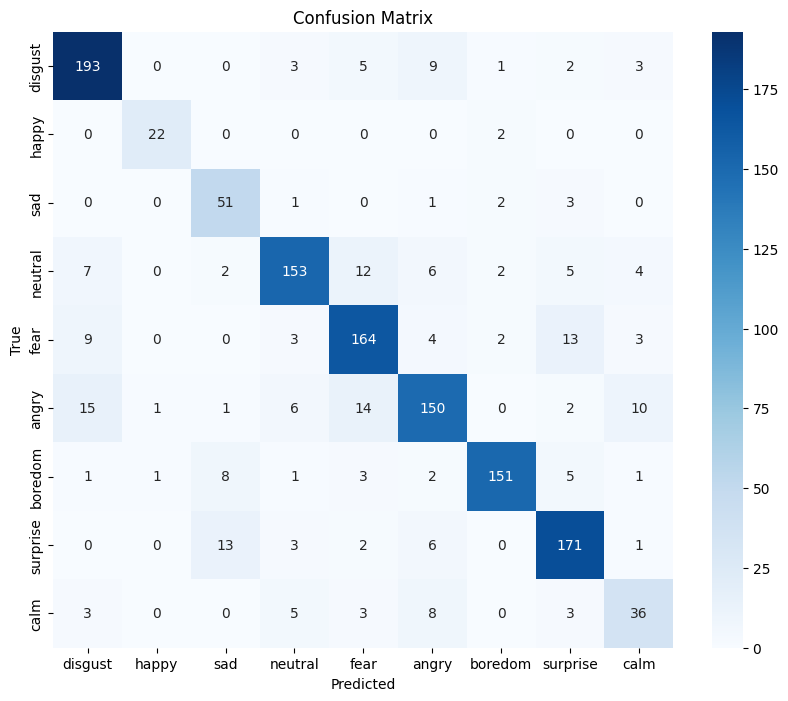

In [79]:
from sklearn.ensemble import RandomForestClassifier
clf12 = RandomForestClassifier()
clf12.fit(X_train_scaled, y_train)
pred12 = clf12.predict(X_test_scaled)
print("Performance RandomForest with feature scaling\n", classification_report(y_test, pred12))

# Generate a confusion matrix
cm = confusion_matrix(y_test, pred12)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Test best cross-dataset SVM with CREMA-D

In [111]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("ejlok1/cremad")
print("Path to dataset files:", path)
# List all files in the dataset
path = path + '/AudioWAV'
crema_directory_list = os.listdir(path)
print(crema_directory_list)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(path + '/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()
print(crema_df.label.value_counts())

label
angry      1271
disgust    1271
sad        1271
fear       1271
happy      1271
neutral    1087
Name: count, dtype: int64


In [112]:
X_crema = smile.process_files(crema_df['path'])
#X_crema.to_csv("CREMA-D_features.csv")
X_crema.head()

,,,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
file,start,end,,,,,,,,,,,,,,,,,,,,,
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/cremad/versions/1/AudioWAV/1022_ITS_ANG_XX.wav,0 days,0 days 00:00:02.435750,33.554379,0.133362,29.844292,32.074005,36.359715,6.515423,75.130508,37.419884,85.780258,70.062393,...,-0.001459,-0.010670,0.219415,2.066116,3.375528,0.130000,0.065000,0.162857,0.168159,-16.657373
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/cremad/versions/1/AudioWAV/1037_ITS_ANG_XX.wav,0 days,0 days 00:00:03.003000,33.797928,0.156689,27.839457,33.943745,39.205154,11.365698,213.228745,224.954208,21.323975,7.774736,...,-0.001692,-0.008970,0.104355,2.675585,2.380953,0.198571,0.097311,0.175000,0.097852,-25.951315
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/cremad/versions/1/AudioWAV/1060_ITS_NEU_XX.wav,0 days,0 days 00:00:02.402375,33.272175,0.040007,32.571785,33.174286,35.001083,2.429298,50.564014,51.252964,11.337610,5.761051,...,-0.003549,-0.005669,0.056235,2.928870,2.136752,0.082000,0.037094,0.303333,0.317263,-39.639580
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/cremad/versions/1/AudioWAV/1075_ITS_NEU_XX.wav,0 days,0 days 00:00:02.435750,33.863213,0.100446,31.627247,32.890541,36.872204,5.244957,98.765892,91.597748,127.040131,70.957596,...,-0.008016,-0.016566,0.076499,2.892562,1.687764,0.112500,0.036315,0.366000,0.337200,-37.282352
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/cremad/versions/1/AudioWAV/1073_IOM_DIS_XX.wav,0 days,0 days 00:00:02.869562500,31.973564,0.051781,29.778587,32.372501,33.615463,3.836876,4.747492,5.274123,11.323006,0.540545,...,-0.016674,-0.010002,0.067577,2.456141,0.714286,0.395000,0.135000,0.653333,0.372767,-33.866997


Performance RandomForest with feature scaling
               precision    recall  f1-score   support

       angry       0.71      0.22      0.34      1271
     boredom       0.00      0.00      0.00         0
        calm       0.00      0.00      0.00         0
     disgust       0.26      0.31      0.28      1271
        fear       0.28      0.28      0.28      1271
       happy       0.44      0.07      0.12      1271
     neutral       0.15      0.11      0.12      1087
         sad       0.26      0.64      0.37      1271
    surprise       0.00      0.00      0.00         0

    accuracy                           0.28      7442
   macro avg       0.23      0.18      0.17      7442
weighted avg       0.35      0.28      0.26      7442



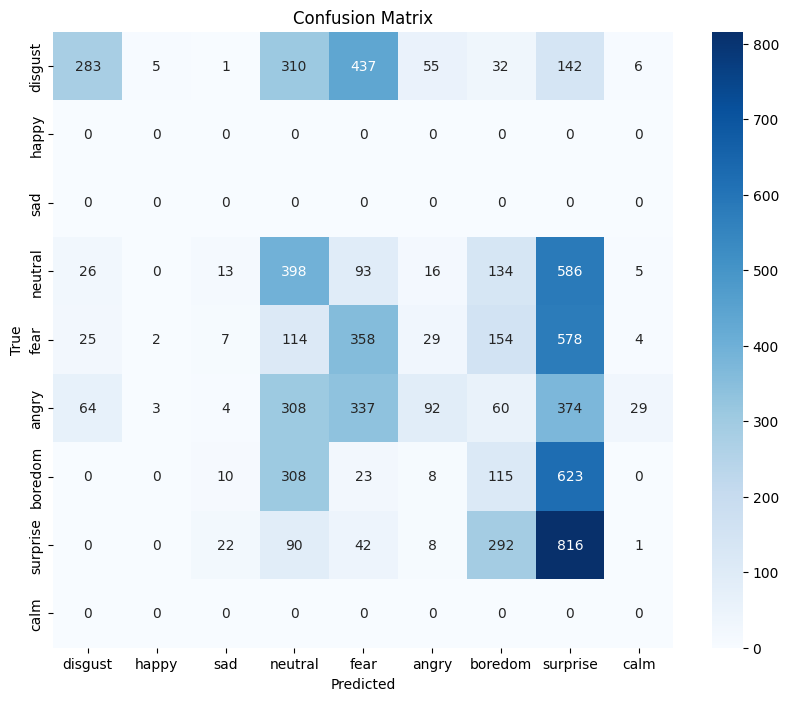

In [118]:
X_cr = X_crema.values
y_crema = crema_df.label

X_crema_scaled = scaler.transform(X_cr)

pred_crema = clf12.predict(X_crema_scaled)
print("Performance RandomForest with feature scaling\n", classification_report(y_crema, pred_crema))

# Generate a confusion matrix
cm = confusion_matrix(y_crema, pred_crema)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# SAVEE

In [122]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
print("Path to dataset files:", path)
# List all files in the dataset
#path = path + '/AudioWAV'
savee_dir = path+'/ALL'
print(os.listdir(savee_dir))

Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1
['JK_sa01.wav', 'JK_sa15.wav', 'DC_n13.wav', 'DC_su09.wav', 'DC_n07.wav', 'JK_n20.wav', 'JK_n08.wav', 'JE_sa08.wav', 'JK_f15.wav', 'JK_f01.wav', 'KL_sa13.wav', 'KL_sa07.wav', 'JK_d03.wav', 'DC_h01.wav', 'DC_h15.wav', 'DC_h14.wav', 'JK_d02.wav', 'KL_sa06.wav', 'KL_sa12.wav', 'JK_f14.wav', 'JE_sa09.wav', 'JK_n09.wav', 'JK_n21.wav', 'DC_n06.wav', 'DC_n12.wav', 'DC_su08.wav', 'JK_sa14.wav', 'JK_sa02.wav', 'DC_n04.wav', 'DC_n10.wav', 'JK_n23.wav', 'JK_f02.wav', 'KL_sa04.wav', 'KL_sa10.wav', 'JK_d14.wav', 'DC_h02.wav', 'DC_h03.wav', 'JK_d15.wav', 'KL_sa11.wav', 'JK_d01.wav', 'KL_sa05.wav', 'JK_f03.wav', 'JK_n22.wav', 'DC_n11.wav', 'DC_n05.wav', 'JK_sa03.wav', 'JK_sa13.wav', 'JK_sa07.wav', 'DC_n29.wav', 'DC_n01.wav', 'DC_n15.wav', 'JK_n26.wav', 'JK_f07.wav', 'JK_f13.wav', 'JK_h08.wav', 'KL_sa01.wav', 'JK_d05.wav', 'KL_sa15.wav', 'JK_d11.wav', 'DC_f08.wav', 'DC_h1

In [124]:
savee_directory_list = os.listdir(savee_dir)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(savee_dir + '/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
savee_df = pd.concat([emotion_df, path_df], axis=1)
savee_df.head()
print(savee_df.label.value_counts())

label
neutral     120
sad          60
surprise     60
fear         60
disgust      60
happy        60
angry        60
Name: count, dtype: int64


In [125]:
X_s = smile.process_files(savee_df['path'])
X_s.to_csv("SAVEE_features.csv")
X_s.head()

,,,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
file,start,end,,,,,,,,,,,,,,,,,,,,,
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/JK_sa01.wav,0 days,0 days 00:00:04.511836735,30.007080,0.272709,25.000589,28.750051,32.279442,7.278852,240.264999,231.647217,108.595650,103.315277,...,-0.124250,-0.006894,0.141440,2.888889,1.573034,0.391429,0.281294,0.195000,0.196278,-18.515924
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/JK_sa15.wav,0 days,0 days 00:00:06.058707483,25.473991,0.217824,22.993029,24.884258,26.689384,3.696356,555.023865,1132.687256,79.383507,57.577232,...,-0.123710,-0.009605,0.107340,3.145695,2.671119,0.216250,0.156400,0.179167,0.186434,-22.415129
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/DC_n13.wav,0 days,0 days 00:00:02.788888889,27.486273,0.234637,23.860952,26.258076,29.287365,5.426413,1114.765137,1384.494995,53.991169,11.393560,...,-0.133652,-0.008191,0.069946,3.249098,1.838235,0.316000,0.188000,0.204000,0.166445,-22.394150
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/DC_su09.wav,0 days,0 days 00:00:03.433968254,36.879757,0.170512,33.624943,35.374607,38.021076,4.396133,128.577591,147.499802,18.332680,21.825897,...,-0.119606,-0.010003,0.110836,3.216374,2.077151,0.267143,0.237830,0.168750,0.179265,-15.458962
/Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/DC_n07.wav,0 days,0 days 00:00:04.051768707,25.581205,0.108522,23.417963,25.015635,28.008581,4.590618,111.322693,142.705490,37.078491,24.161617,...,-0.133119,-0.007635,0.072440,2.227723,1.002506,0.637500,0.326449,0.270000,0.190578,-22.507835


Performance RandomForest with feature scaling
               precision    recall  f1-score   support

       angry       0.18      0.03      0.06        60
     boredom       0.00      0.00      0.00         0
     disgust       0.04      0.03      0.04        60
        fear       1.00      0.05      0.10        60
       happy       0.05      0.03      0.04        60
     neutral       0.03      0.01      0.01       120
         sad       0.19      0.92      0.32        60
    surprise       0.00      0.00      0.00        60

    accuracy                           0.14       480
   macro avg       0.19      0.13      0.07       480
weighted avg       0.19      0.14      0.07       480



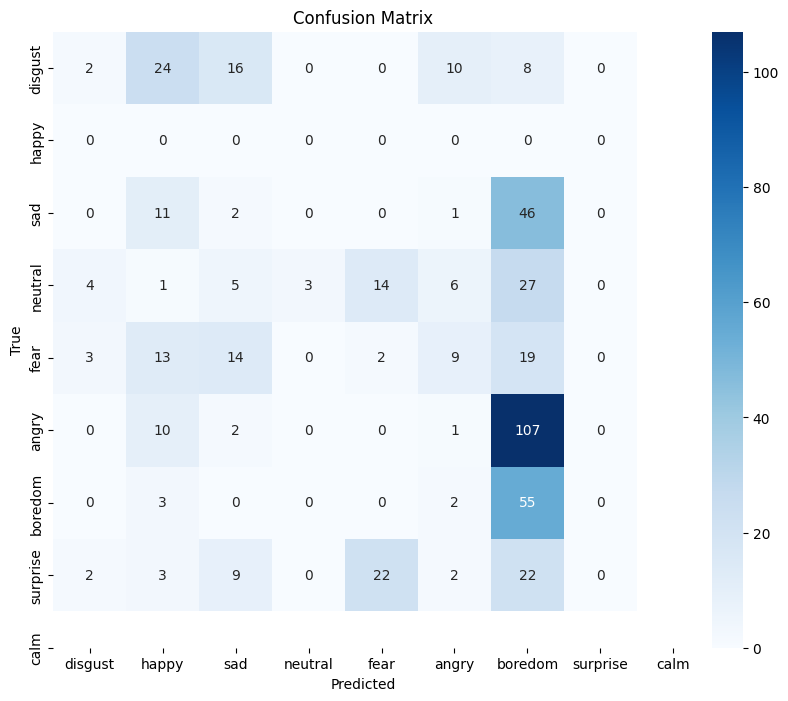

In [126]:
X_savee = X_s.values
y_savee = savee_df.label

X_savee_scaled = scaler.transform(X_savee)

pred_savee = clf12.predict(X_savee_scaled)
print("Performance RandomForest with feature scaling\n", classification_report(y_savee, pred_savee))

# Generate a confusion matrix
cm = confusion_matrix(y_savee, pred_savee)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# MLPClassifier

              precision    recall  f1-score   support

       angry       0.89      0.88      0.88       216
     boredom       0.95      0.83      0.89        24
        calm       0.63      0.67      0.65        58
     disgust       0.86      0.85      0.86       191
        fear       0.82      0.81      0.82       198
       happy       0.77      0.80      0.78       199
     neutral       0.87      0.88      0.88       173
         sad       0.83      0.81      0.82       196
    surprise       0.74      0.74      0.74        58

    accuracy                           0.83      1313
   macro avg       0.82      0.81      0.81      1313
weighted avg       0.83      0.83      0.83      1313



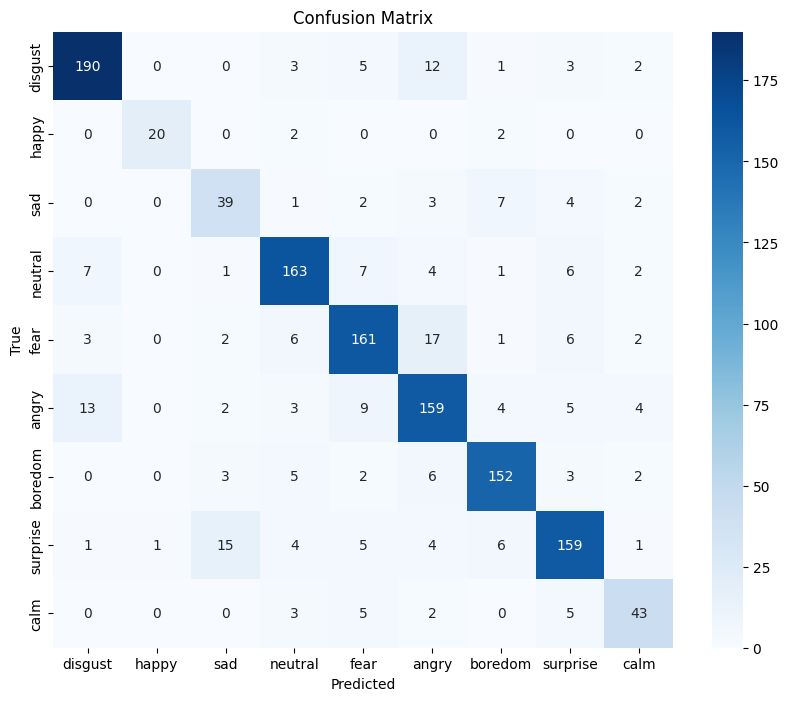

In [97]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Feature scaling is CRUCIAL for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42,
    alpha=0.0001
)

# Train
mlp.fit(X_train_scaled, y_train)
#mlp.fit(X_train, y_train)

# Evaluate
pred_mlp = mlp.predict(X_test_scaled) #83%
#pred_mlp = mlp.predict(X_test) # 60%
print(classification_report(y_test, pred_mlp))

# Generate a confusion matrix
cm = confusion_matrix(y_test, pred_mlp)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [83]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(100,), (100,50), (100,50,25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

grid = GridSearchCV(MLPClassifier(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100,), (100, 50),
                                                (100, 50, 25)]})

In [85]:
grid.best_params_

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}

In [95]:
grid.best_score_

0.8327863608738765

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define classifiers and parameter grids
classifiers = {
    'SVM': {
        'model': SVC(),
        'params': {
            'clf__C': [0.1, 1, 10, 100],
            'clf__kernel': ['linear', 'rbf', 'poly'],
            'clf__gamma': ['scale', 'auto', 0.1, 1]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'clf__n_estimators': [100, 200, 300],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5, 10]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear', 'saga']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'clf__n_neighbors': [3, 5, 7, 9],
            'clf__weights': ['uniform', 'distance']
        }
    }
}

# Store results
results = []

for name, classifier in classifiers.items():
    # Create pipeline with scaler and classifier
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', classifier['model'])
    ])
    
    # Grid Search with 10-fold CV
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=classifier['params'],
        cv=10,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    # Store results
    results.append({
        'model': name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'test_score': grid.score(X_test, y_test)
    })
    
    print(f"\n{name} Best Parameters: {grid.best_params_}")
    print(f"Validation Accuracy: {grid.best_score_:.3f}")
    print(f"Test Accuracy: {grid.score(X_test, y_test):.3f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['model', 'best_score', 'test_score']])

Fitting 10 folds for each of 48 candidates, totalling 480 fits

SVM Best Parameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Validation Accuracy: 0.840
Test Accuracy: 0.848
Fitting 10 folds for each of 27 candidates, totalling 270 fits

RandomForest Best Parameters: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Validation Accuracy: 0.840
Test Accuracy: 0.839
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 


LogisticRegression Best Parameters: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Validation Accuracy: 0.795
Test Accuracy: 0.794
Fitting 10 folds for each of 8 candidates, totalling 80 fits

KNN Best Parameters: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
Validation Accuracy: 0.793
Test Accuracy: 0.794

Model Comparison:
                model  best_score  test_score
0                 SVM    0.839646    0.847677
1        RandomForest    0.839641    0.839299
2  LogisticRegression    0.794892    0.794364
3                 KNN    0.792617    0.794364


In [99]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from src.select_features import FeatureSelector

# Create pipeline with fixed SVM params and feature selector
pipeline = Pipeline([
    ('selector', FeatureSelector()),
    ('clf', SVC(C=10, gamma='scale', kernel='rbf', random_state=42))  # Fixed SVM params
])

# Define parameter grid for feature selection
param_grid = {
    'selector__algorithm': ['algorithm1', 'algorithm2'],
    'selector__L': [0.7, 0.8, 0.9, 0.95],
    'selector__MS': [0.7, 0.75, 0.8],  # Only used with algorithm2
    'selector__dispersion_measure': ['MM', 'MAD', 'TV', 'AMGM']
}

# Configure grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Run grid search
grid_search.fit(X_train, y_train)

# Results analysis
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test, y_test))

# Save results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv('feature_selection_grid_search_results.csv', index=False)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.5s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__disp

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   1.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__disper

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.7s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.7s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.6s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__disper

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.8s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.5s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.5s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.5s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__di

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__disper

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, se

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, se

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.3s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   1.9s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.1s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=   2.0s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__

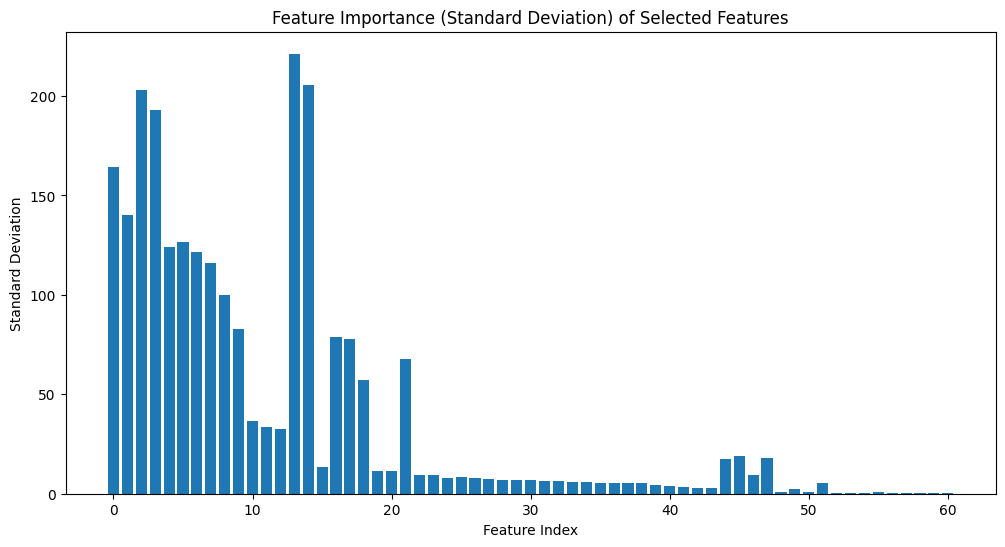

In [100]:

best_selector = grid_search.best_estimator_.named_steps['selector']
plt.figure(figsize=(12, 6))
plt.bar(range(len(best_selector.selected_indices)), 
        X_train.std(axis=0)[best_selector.selected_indices])
plt.title('Feature Importance (Standard Deviation) of Selected Features')
plt.xlabel('Feature Index')
plt.ylabel('Standard Deviation')
plt.show()